## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [289]:
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np

In [290]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)


def get_prob(sequence: np.ndarray, classes: np.ndarray) -> tuple[float, float]:
    size = sequence.shape[0]
    class_1 = np.count_nonzero(sequence == classes[0])
    class_2 = np.count_nonzero(sequence == classes[1])

    return class_1 / size, class_2 / size


CriterionFunction = Callable[[np.ndarray], float]


def gini(sequence: np.ndarray) -> float:
    if len(np.unique(sequence)) < 2:
        return 0
    p1, p2 = get_prob(sequence, np.unique(sequence))
    return 1 - np.square(p1) - np.square(p2)


def entropy(sequence: np.ndarray) -> float:
    if len(np.unique(sequence)) < 2:
        return 0
    p1, p2 = get_prob(sequence, np.unique(sequence))

    return -(p1 * np.log2(p1) + p2 * np.log2(p2))


In [291]:
# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])

In [292]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [293]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [294]:
import pandas as pd

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")


x_train: np.ndarray = train_df.loc[:, train_df.columns != "price_range"].to_numpy()  # type: ignore
y_train: np.ndarray = train_df.loc[:, "price_range"].to_numpy()
x_val: np.ndarray = val_df.loc[:, train_df.columns != "price_range"].to_numpy()  # type: ignore
y_val: np.ndarray = val_df.loc[:, "price_range"].to_numpy()

print(train_df.shape)
print(val_df.shape)
train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [295]:
from dataclasses import dataclass


@dataclass
class Node:
    feature: Optional[int] = None
    threshold: Optional[float] = None
    l_node: Optional["Node"] = None
    r_node: Optional["Node"] = None
    mark: Optional[int] = None

    def is_leaf(self):
        return self.mark is not None

In [296]:
n_train_samples, n_train_feats = train_df.shape


def convert_vote(data: np.ndarray) -> np.ndarray:
    def replacer(x: int):
        return -1 if x == 0 else x

    return np.vectorize(replacer)(data)


class DecisionTree:
    def __init__(
        self, criterion="gini", max_depth=None, negative=False, max_features=None
    ):
        self.criterion = {"gini": gini, "entropy": entropy}[criterion]
        self.max_depth = max_depth
        self.importance = np.zeros(n_train_feats - 1)
        self.negative = negative
        self.max_features = max_features
        self.rng = np.random.default_rng()

    def get_accuracy(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return np.count_nonzero(y_pred == y_true) / len(y_pred)

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        self.root = self.build_tree(x_data, y_data)

    def predict(self, x_data: np.ndarray) -> np.ndarray:
        pred = np.array([self.traverse_tree(x, self.root) for x in x_data])
        if self.negative:
            return convert_vote(pred)
        return pred

    def traverse_tree(self, x: np.ndarray, node: Node):
        if node.is_leaf():
            return node.mark
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.l_node)  # type: ignore

        return self.traverse_tree(x, node.r_node)  # type: ignore

    def build_tree(
        self, x_data: np.ndarray, y_data: np.ndarray, depth: int = 0
    ) -> Node:
        if (self.max_depth is not None and depth >= self.max_depth) or (
            len(np.unique(y_data)) < 2
        ):
            leaf_mark = self.class_mark(y_data)
            return Node(mark=leaf_mark)

        feat_index, thres = self.best_split(x_data, y_data)
        l_index, r_index = self.split(x_data[:, feat_index], thres)

        current_uncertainty = self.criterion(y_data)
        info = self.info_gain(
            current_uncertainty,
            y_data[l_index],
            y_data[r_index],
        )

        if info == 0:
            leaf_mark = self.class_mark(y_data)
            return Node(mark=leaf_mark)
        left = self.build_tree(x_data[l_index], y_data[l_index], depth + 1)
        right = self.build_tree(x_data[r_index], y_data[r_index], depth + 1)

        self.importance[feat_index] += 1
        return Node(feature=feat_index, threshold=thres, l_node=left, r_node=right)

    def split(self, feat_col: np.ndarray, thres: int):
        l_index = np.argwhere(feat_col <= thres).flatten()
        r_index = np.argwhere(feat_col > thres).flatten()

        return l_index, r_index

    def best_split(self, x_data: np.ndarray, y_data: np.ndarray):
        n_feat = x_data.shape[1]

        if self.max_features is not None:
            feats = self.rng.choice(n_feat, size=self.max_features, replace=False)
        else:
            feats = range(n_feat)

        best_error = 1
        split_index, split_thres = 0, 0
        for feat_index in feats:  # type: ignore
            feat_col = x_data[:, feat_index]
            thresholds = np.unique(feat_col)
            for thres in thresholds:
                error = self.calculate_error(x_data, y_data, feat_col, thres)

                if error < best_error:
                    best_error = error
                    split_index = feat_index
                    split_thres = thres

        return split_index, split_thres

    def info_gain(self, current: float, left: np.ndarray, right: np.ndarray):
        p = len(left) / (len(left) + len(right))
        return current - p * self.criterion(left) - (1 - p) * self.criterion(right)

    def calculate_error(
        self,
        x_data: np.ndarray,
        y_data: np.ndarray,
        feat_col: np.ndarray,
        thres: int,
    ) -> float:
        n_samples, _ = x_data.shape
        l_index, r_index = self.split(feat_col, thres)
        if len(l_index) == 0 or len(r_index) == 0:
            return 1
        l_criterion = self.criterion(y_data[l_index])
        r_criterion = self.criterion(y_data[r_index])
        criterion_index = l_criterion * (l_index.shape[0] / n_samples) + r_criterion * (
            r_index.shape[0] / n_samples
        )

        return criterion_index

    def class_mark(self, y_data: np.ndarray):
        mark = np.argmax(np.bincount(y_data))
        return int(mark)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [297]:
clf_depth3 = DecisionTree(criterion="gini", max_depth=3)
clf_depth3.fit(x_train, y_train)
y_pred = clf_depth3.predict(x_val)
acc = clf_depth3.get_accuracy(y_pred, y_val)
print(f"clf_depth3 acc: {acc}")

clf_depth10 = DecisionTree(criterion="gini", max_depth=10)
clf_depth10.fit(x_train, y_train)
y_pred = clf_depth10.predict(x_val)
acc = clf_depth10.get_accuracy(y_pred, y_val)
print(f"clf_depth10 acc: {acc}")


clf_depth3 acc: 0.9166666666666666
clf_depth10 acc: 0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [298]:
clf_gini = DecisionTree(criterion="gini", max_depth=3)
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_val)
acc = clf_gini.get_accuracy(y_pred, y_val)
print(f"clf_gini acc: {acc}")

clf_entropy = DecisionTree(criterion="entropy", max_depth=3)
clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_val)
acc = clf_entropy.get_accuracy(y_pred, y_val)
print(f"clf_entropy acc: {acc}")


clf_gini acc: 0.9166666666666666
clf_entropy acc: 0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

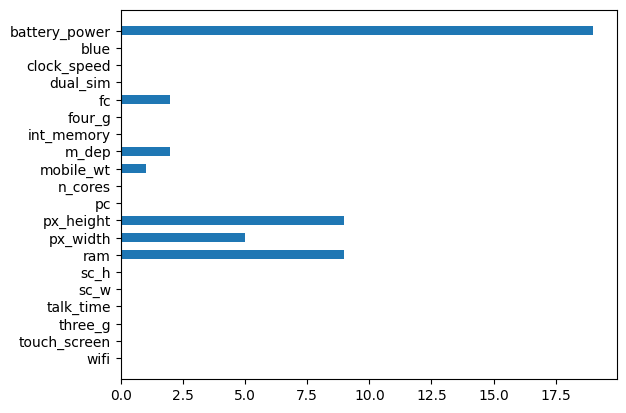

In [299]:
# print(x_train.columns.to_list())
plt.barh(
    range(clf_depth10.importance.shape[0], 0, -1),
    clf_depth10.importance,
    tick_label=train_df.loc[:, train_df.columns != "price_range"].columns,
    height=0.5,
)
plt.show()


## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [300]:
class AdaBoost:
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.clfs: list[DecisionTree] = []
        self.alpha: list[float] = []

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        self.clfs = []
        y_series = convert_vote(y_data)
        n_samples = x_data.shape[0]
        w = np.full(n_samples, 1 / n_samples)

        for _ in range(self.n_estimators):
            weighted_index = np.random.choice(n_samples, n_samples, p=w)
            weighted_x_train = x_data[weighted_index]
            weighted_y_train = y_data[weighted_index]

            clf = DecisionTree(criterion="gini", max_depth=1, negative=True)
            clf.fit(weighted_x_train, weighted_y_train)
            y_pred = clf.predict(x_data)

            error = self.loss_function(y_pred, y_series, w)
            alpha = 0.5 * np.log((1 - error) / error)
            if error > 0.5:
                self.alpha.append(-alpha)
            else:
                self.alpha.append(alpha)

            self.clfs.append(clf)
            w = w * np.exp(-alpha * y_pred * y_series)
            w = w / np.sum(w)

    def predict(self, x_data: np.ndarray):
        y_pred = np.zeros(x_data.shape[0])
        for clf, alpha in zip(self.clfs, self.alpha):
            y = clf.predict(x_data)
            y = y * alpha
            y_pred = y_pred + y

        return y_pred > 0

    def loss_function(self, y_pred: np.ndarray, y_data: np.ndarray, w: np.ndarray):
        error = w * (y_pred != y_data)
        return np.sum(error)

    def get_accuracy(self, y_pred: np.ndarray, y_true: np.ndarray):
        return np.count_nonzero(y_pred == y_true) / len(y_pred)

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [301]:
clf_10 = AdaBoost(10)
clf_10.fit(x_train, y_train)
y_pred = clf_10.predict(x_val)
acc = clf_10.get_accuracy(y_pred, y_val)
print(f"clf_10 acc: {acc}")

clf_10 acc: 0.9366666666666666


In [302]:
clf_100 = AdaBoost(100)
clf_100.fit(x_train, y_train)
y_pred = clf_100.predict(x_val)
acc = clf_100.get_accuracy(y_pred, y_val)
print(f"clf_100 acc: {acc}")

clf_100 acc: 0.9733333333333334


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [303]:
class RandomForest:
    def __init__(
        self,
        n_estimators,
        max_features,
        bootstrap=True,
        criterion="gini",
        max_depth=None,
    ):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.clfs: list[DecisionTree] = []

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        self.clfs = []
        generator = np.random.default_rng()
        n_samples = x_data.shape[0]
        if self.bootstrap:
            data_index = generator.choice(n_samples, n_samples)
            x_data = x_data[data_index]
            y_data = y_data[data_index]

        for _ in range(self.n_estimators):
            clf = DecisionTree(
                criterion=self.criterion,
                max_depth=self.max_depth,
                max_features=self.max_features,
                negative=True,
            )
            clf.fit(x_data=x_data, y_data=y_data)
            self.clfs.append(clf)

    def predict(self, x_data: np.ndarray):
        vote = np.zeros(x_data.shape[0])
        i = 0
        for clf in self.clfs:
            i += 1
            y_pred = clf.predict(x_data=x_data)
            vote = vote + y_pred

        return vote > 0

    def get_accuracy(self, y_pred: np.ndarray, y_true: np.ndarray):
        return np.count_nonzero(y_pred == y_true) / len(y_pred)


### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [304]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [305]:
clf_10tree.fit(x_data=x_train, y_data=y_train)
y_pred = clf_10tree.predict(x_data=x_val)
acc = clf_10tree.get_accuracy(y_pred=y_pred, y_true=y_val)
print(f"clf_10tree acc: {acc}")

clf_100tree.fit(x_data=x_train, y_data=y_train)
y_pred = clf_100tree.predict(x_data=x_val)
acc = clf_100tree.get_accuracy(y_pred=y_pred, y_true=y_val)
print(f"clf_100tree acc: {acc}")

clf_10tree acc: 0.9166666666666666
clf_100tree acc: 0.9233333333333333


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [306]:
clf_random_features = RandomForest(
    n_estimators=10, max_features=np.sqrt(x_train.shape[1])
)
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [307]:
clf_random_features.fit(x_data=x_train, y_data=y_train)
y_pred = clf_random_features.predict(x_data=x_val)
acc = clf_random_features.get_accuracy(y_pred=y_pred, y_true=y_val)
print(f"clf_random_features acc: {acc}")

clf_all_features.fit(x_data=x_train, y_data=y_train)
y_pred = clf_all_features.predict(x_data=x_val)
acc = clf_all_features.get_accuracy(y_pred=y_pred, y_true=y_val)
print(f"clf_all_features acc: {acc}")


clf_random_features acc: 0.9233333333333333
clf_all_features acc: 0.94


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [308]:
def train_your_model(data):
    ## Define your model and training
    x_train: np.ndarray = data.loc[:, train_df.columns != "price_range"].to_numpy()  # type: ignore
    y_train: np.ndarray = data.loc[:, "price_range"].to_numpy()

    ada_100 = AdaBoost(50)
    ada_100.fit(x_train, y_train)

    return ada_100

In [309]:
train_merge = pd.concat([train_df, val_df], ignore_index=True)
my_model = train_your_model(train_merge)

In [310]:
y_pred = my_model.predict(x_val)
acc = my_model.get_accuracy(y_pred, y_val)

print(f"my_model acc: {acc}")

my_model acc: 0.9766666666666667


In [312]:
assert y_pred.shape == (500,)

AssertionError: 

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

y_test = pd.read_csv("y_test.csv")["price_range"].values

print("Test-set accuarcy score: ", accuracy_score(y_test, y_pred))

In [313]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(
    score, thres, CLS, kwargs, name, x_train, y_train, x_test, y_test, patient=10
):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = (
        "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    )
    df = pd.read_csv(
        file_url,
        names=[
            "Length",
            "Diameter",
            "Height",
            "Whole weight",
            "Shucked weight",
            "Viscera weight",
            "Shell weight",
            "Age",
        ],
    )

    df["Target"] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df["Target"].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df["Target"].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(
    5,
    0.9337,
    DecisionTree(criterion="gini", max_depth=3),
    "DecisionTree(criterion='gini', max_depth=3)",
    x_train,
    y_train,
    x_test,
    y_test,
)

score += discrete_checker(
    2.5,
    0.9036,
    DecisionTree(criterion="gini", max_depth=10),
    "DecisionTree(criterion='gini', max_depth=10)",
    x_train,
    y_train,
    x_test,
    y_test,
)

score += discrete_checker(
    2.5,
    0.9096,
    DecisionTree(criterion="entropy", max_depth=3),
    "DecisionTree(criterion='entropy', max_depth=3)",
    x_train,
    y_train,
    x_test,
    y_test,
)

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5,
    0.91,
    AdaBoost,
    {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train,
    y_train,
    x_test,
    y_test,
)

score += patient_checker(
    7.5,
    0.87,
    AdaBoost,
    {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train,
    y_train,
    x_test,
    y_test,
)

score += patient_checker(
    5,
    0.91,
    RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train,
    y_train,
    x_test,
    y_test,
)

score += patient_checker(
    5,
    0.91,
    RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train,
    y_train,
    x_test,
    y_test,
)

score += patient_checker(
    5,
    0.92,
    RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train,
    y_train,
    x_test,
    y_test,
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
